# Gendered Hate Speech Classifier
#### Author: E Felix, 33693197

### Setting Up...

!! Data Source: Fersini, E., Rosso, P., & Anzovino, M. (2018). Overview of the Task on Automatic Misogyny Identification at IberEval 2018. In IberEval@ SEPLN (pp. 214-228).

In [1]:
import sklearn
import nltk
import re
import string
import numpy as np
import pandas as pd

# download nltk's wordnet
nltk.download('wordnet')

# load data
file_path = 'en_training.tsv'
data = pd.read_csv(file_path, delimiter='\t') # TSV FILE = \t

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erlindafelix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# split misogyny_category into labels for multi-label classification
data['labels'] = data['misogyny_category'].apply(lambda x: x.split(','))

# binarize the labels
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(data['labels'])

print("Classes:", mlb.classes_)

Classes: ['0' 'derailing' 'discredit' 'dominance' 'sexual_harassment' 'stereotype']


In [4]:
# --- text pre processing ---
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# function to clean text: lowercasing & remove url, numbers, punctuation, stopwords
def clean(text):
    text = str(text).lower()   
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)   
    text = re.sub(r'\w*\d\w*', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in stopwords.words('english')])
   
    # stem words to make them as basic as possible
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

# call the function
data['text'] = data['text'].apply(clean)

print(data.head())

   id                                               text  misogynous  \
0   1  plea tell bitch next pierc line judgment every...           1   
1   2                                    bitch shut fuck           1   
2   3                  abzdafab dear cunt plea shut fuck           1   
3   4              rt queenofdragonsb pl shut fuck bitch           1   
4   5  rt  u gonna get licen shut fuck bitch aint got...           1   

  misogyny_category  target       labels  
0         dominance  active  [dominance]  
1         dominance  active  [dominance]  
2         dominance  active  [dominance]  
3         dominance  active  [dominance]  
4         dominance  active  [dominance]  


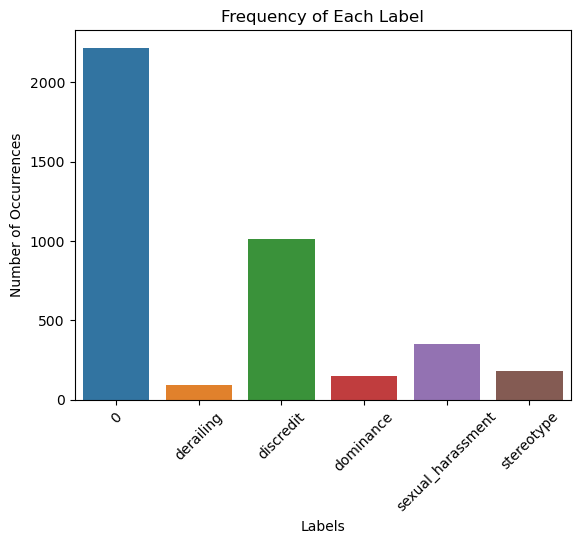

In [7]:
# --- visualize label data ---
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = np.sum(y_encoded, axis=0)
sns.barplot(x=mlb.classes_, y=label_counts)
plt.title('Frequency of Each Label')
plt.ylabel('Number of Occurrences')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.show()

### Splitting the data

In [5]:
from zlib import crc32

# custom split function, HOML text book (chapter 2)

#  test set checking function
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# function to split data by id
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [6]:
# --- split the data ---
train_data, test_data = split_train_test_by_id(data, test_ratio=0.2, id_column='id')

# label and feature extraction
X_train = train_data['misogyny_category']
y_train = y_encoded[train_data.index]
X_test = test_data['misogyny_category']
y_test = y_encoded[test_data.index]

### Machine learning pipeline: TFIDF + Multi label output wrapped MNB

In [8]:
# --- setting up the pl ---
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('class', MultiOutputClassifier(MultinomialNB())),
])

In [9]:
# fit the pl
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# --- print the results ---
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

                   precision    recall  f1-score   support

                0       0.73      1.00      0.84       441
        derailing       1.00      1.00      1.00        21
        discredit       1.00      1.00      1.00       193
        dominance       1.00      1.00      1.00        32
sexual_harassment       1.00      1.00      1.00        74
       stereotype       1.00      1.00      1.00        38

        micro avg       0.83      1.00      0.91       799
        macro avg       0.95      1.00      0.97       799
     weighted avg       0.85      1.00      0.91       799
      samples avg       0.90      1.00      0.93       799

Accuracy: 0.7934918648310388


### Cross Validation

In [11]:
from sklearn.model_selection import KFold, cross_val_score

# data['misogyny_category'] = feature data
# y_encoded = binarized labels

# --- set up kfold ---
kfld = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, data['misogyny_category'], y_encoded, cv=kfld, scoring='accuracy')

print("Accuracy scores for each fold:", scores)
print("Average Accuracy score:", scores.mean())
print("Standard deviation of cross-validation scores: ", scores.std())

print("\n\n")

scores = cross_val_score(pipeline, data['misogyny_category'], y_encoded, cv=kfld, scoring='precision_micro')

print("Precision (Micro) scores for each fold:", scores)
print("Average Precision (Micro)  score:", scores.mean())
print("Standard deviation of cross-validation scores: ", scores.std())

print("\n\n")

scores = cross_val_score(pipeline, data['misogyny_category'], y_encoded, cv=kfld, scoring='recall_micro')

print("Recall (Micro) scores for each fold:", scores)
print("Average Recall (Micro)  score:", scores.mean())
print("Standard deviation of cross-validation scores: ", scores.std())

print("\n")

scores = cross_val_score(pipeline, data['misogyny_category'], y_encoded, cv=kfld, scoring='f1_micro')

print("F1 (Micro) scores for each fold:", scores)
print("Average F1 (Micro)  score:", scores.mean())
print("Standard deviation of cross-validation scores: ", scores.std())

print("\n")

scores = cross_val_score(pipeline, data['misogyny_category'], y_encoded, cv=kfld, scoring='roc_auc')

print("ROC AUC scores for each fold:", scores)
print("Average ROC AUC  score:", scores.mean())
print("Standard deviation of cross-validation scores: ", scores.std())

print("\n")


Accuracy scores for each fold: [0.78875 0.8125  0.805   0.81375 0.81625]
Average Accuracy score: 0.80725
Standard deviation of cross-validation scores:  0.009981232388838582



Precision (Micro) scores for each fold: [0.8255934  0.84210526 0.83682008 0.84299262 0.84477297]
Average Precision (Micro)  score: 0.838456866634466
Standard deviation of cross-validation scores:  0.006955932316862011



Recall (Micro) scores for each fold: [1. 1. 1. 1. 1.]
Average Recall (Micro)  score: 1.0
Standard deviation of cross-validation scores:  0.0


F1 (Micro) scores for each fold: [0.9044658  0.91428571 0.91116173 0.91480846 0.91585575]
Average F1 (Micro)  score: 0.9121154920154332
Standard deviation of cross-validation scores:  0.00413228632583189


ROC AUC scores for each fold: [0.92702936 0.92897727 0.92550143 0.92945076 0.92919075]
Average ROC AUC  score: 0.9280299150760116
Standard deviation of cross-validation scores:  0.0015269677686822044


